# Name : Gundorov Valentin


# id 336490271

# Perform standard imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sn 
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# Load the CIFAR-10 dataset

In [2]:
transform = transforms.ToTensor()

train_data = datasets.CIFAR10(root='C:/Users/gundo/Data/Data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='C:/Users/gundo/Data/Data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
print(train_data)
test_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: C:/Users/gundo/Data/Data
    Split: Train
    StandardTransform
Transform: ToTensor()


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: C:/Users/gundo/Data/Data
    Split: Test
    StandardTransform
Transform: ToTensor()

# Create loaders

In [4]:
torch.manual_seed(101)  # for reproducible results

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [5]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

# View a batch of images

Label: [    1     5     8     1     6     1     6     3     7     9]
Class:    car   dog  ship   car  frog   car  frog   cat horse truck


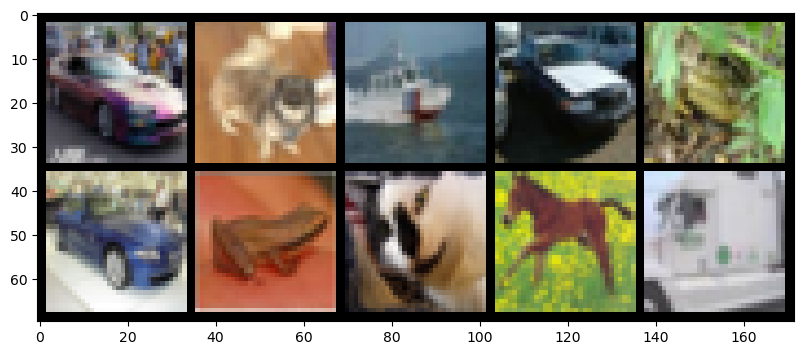

In [6]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

for images,labels in train_loader: 
    break


print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))


im = make_grid(images, nrow=5)  
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

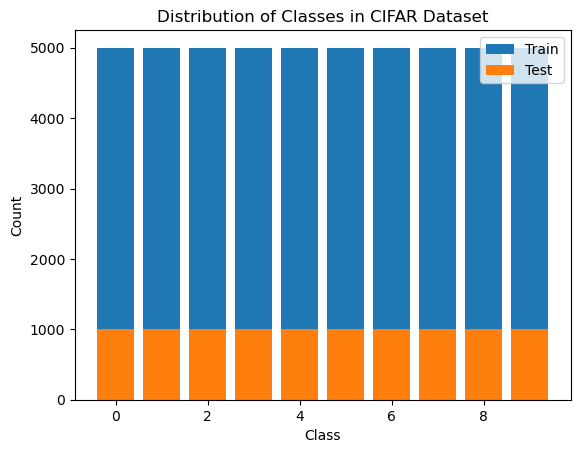

In [7]:
class PlotDist:
    def __init__(self, train_dataset, test_dataset):
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset

    def plot(self):
        train_classes_count = {}
        for _, label in self.train_dataset:
            if label not in train_classes_count:
                train_classes_count[label] = 0
            train_classes_count[label] += 1

        test_classes_count = {}
        for _, label in self.test_dataset:
            if label not in test_classes_count:
                test_classes_count[label] = 0
            test_classes_count[label] += 1

        fig, ax = plt.subplots()
        ax.bar(train_classes_count.keys(), train_classes_count.values(), label='Train')
        ax.bar(test_classes_count.keys(), test_classes_count.values(), label='Test')
        ax.set_xlabel('Class')
        ax.set_ylabel('Count')
        ax.set_title('Distribution of Classes in CIFAR Dataset')
        ax.legend()
        plt.show()

plotter = PlotDist(train_data, test_data)
plotter.plot()

# Define the model

In [8]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)  
        self.conv2 = nn.Conv2d(6, 16, 3, 1) # 6 filters, 16 random number of filters ,3by3 image kernel 
        self.fc1 = nn.Linear(576, 120)   #6*6*16=576
        self.fc2 = nn.Linear(120,84) 
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 576)                 #6*6*16=576
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [9]:
images[0].shape

torch.Size([3, 32, 32])

CIFAR the result is(((32−2)/2)−2)/2=6.5

which rounds down to 6 pixels per side.

In [10]:
model = ConvolutionalNetwork()
print(model)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [11]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    total_params = sum(params)
    for item in params:
        print(f'{item:>6}')
    print(f'  ___\n{total_params:>6}')

In [12]:
print(count_parameters(model))

   162
     6
   864
    16
 69120
   120
 10080
    84
   840
    10
  ___
 81302
None


# Define loss function & optimizer

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model

In [14]:
epochs = 23
train_losses = []
test_losses = []
train_correct = []
test_correct = []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    trn_loss = 0.0
    tst_loss = 0.0
    
    
    model.train()  
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1

        X_train, y_train = X_train.to(device), y_train.to(device)

        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        trn_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_losses.append(trn_loss / len(train_loader))
    train_correct.append(trn_corr)
        
    model.eval()  
    with torch.no_grad():
        for X_test, y_test in test_loader:

            X_test, y_test = X_test.to(device), y_test.to(device)

            y_val = model(X_test)

            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            tst_loss += criterion(y_val, y_test).item()
            
    test_losses.append(tst_loss / len(test_loader))
    test_correct.append(tst_corr)

    print(f'Epoch [{i+1}/{epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {trn_corr.item() / len(train_loader.dataset) * 100:.2f}%, '
          f'Test Loss: {test_losses[-1]:.4f}, Test Acc: {tst_corr.item() / len(test_loader.dataset) * 100:.2f}%')


Epoch [1/23], Train Loss: 1.6317, Train Acc: 39.82%, Test Loss: 1.3750, Test Acc: 50.02%
Epoch [2/23], Train Loss: 1.3322, Train Acc: 52.40%, Test Loss: 1.2277, Test Acc: 55.75%
Epoch [3/23], Train Loss: 1.2040, Train Acc: 57.38%, Test Loss: 1.1939, Test Acc: 57.65%
Epoch [4/23], Train Loss: 1.1269, Train Acc: 60.05%, Test Loss: 1.1330, Test Acc: 59.63%
Epoch [5/23], Train Loss: 1.0731, Train Acc: 62.03%, Test Loss: 1.1401, Test Acc: 59.85%
Epoch [6/23], Train Loss: 1.0242, Train Acc: 63.89%, Test Loss: 1.0996, Test Acc: 61.11%
Epoch [7/23], Train Loss: 0.9844, Train Acc: 65.18%, Test Loss: 1.0956, Test Acc: 61.64%
Epoch [8/23], Train Loss: 0.9470, Train Acc: 66.34%, Test Loss: 1.1157, Test Acc: 61.18%
Epoch [9/23], Train Loss: 0.9130, Train Acc: 67.79%, Test Loss: 1.1517, Test Acc: 61.13%
Epoch [10/23], Train Loss: 0.8791, Train Acc: 68.75%, Test Loss: 1.1545, Test Acc: 60.97%
Epoch [11/23], Train Loss: 0.8489, Train Acc: 70.04%, Test Loss: 1.1788, Test Acc: 60.24%
Epoch [12/23], Trai

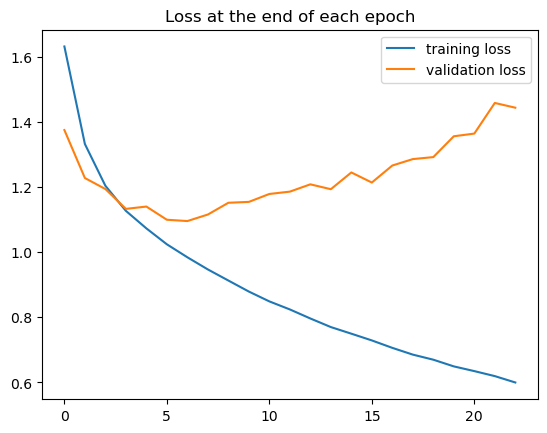

In [15]:
train_losses_tensor = torch.tensor(train_losses)
test_losses_tensor = torch.tensor(test_losses)

train_losses_np = train_losses_tensor.detach().numpy()
test_losses_np = test_losses_tensor.detach().numpy()

plt.plot(train_losses_np, label='training loss')
plt.plot(test_losses_np, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()
plt.show()


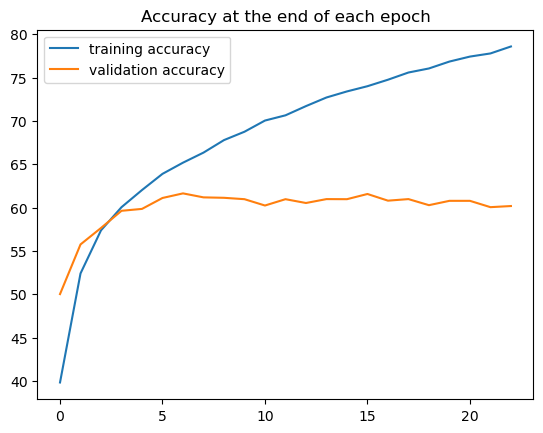

In [16]:
plt.plot([t/500 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

# Evaluate Test Data

In [17]:
print(test_correct[1].item())
print(test_correct[-1].item())

5575
6018


In [18]:
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%')

Test accuracy: 60.180%


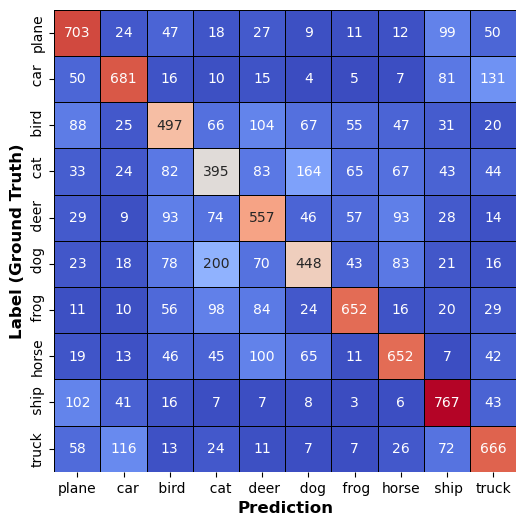

In [35]:

test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)

plt.figure(figsize=(9, 6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='coolwarm', linewidths=0.5, linecolor='black', cbar=False, square=True, annot_kws={"size": 10})
plt.xlabel("Prediction", fontsize=12, fontweight='bold')
plt.ylabel("Label (Ground Truth)", fontsize=12, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


In [26]:
misses = (predicted != y_test).nonzero().view(-1)

# Display the number of misses
num_misses = len(misses)
print("Number of misses:", num_misses)

Number of misses: 3982


In [27]:
print("First 7 index positions:", misses[:7].numpy())

First 7 index positions: [    0     1     2     4     7    12    14]


Index: tensor([ 0,  1,  2,  4,  7, 12, 14])
Label: [    3     8     8     6     6     5     9]
Class:   cat  ship  ship  frog  frog   dog truck

Guess: [    5     0     1     4     2     4     1]
Class:   dog plane   car  deer  bird  deer   car


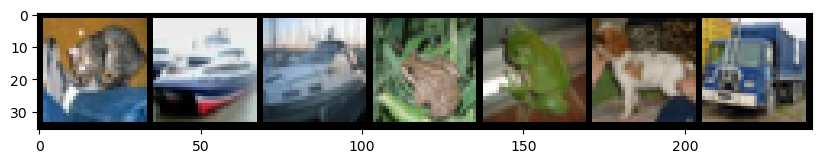

In [34]:
r = 7
row = iter(np.array_split(misses, len(misses) // r + 1))
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) 

nextrow = next(row)
labels = y_test[nextrow].numpy()
guesses = predicted[nextrow].numpy()
print("Index:", nextrow)
print("Label:", labels)
print("Class:", *[class_names[i] for i in labels]) 

print()
print("Guess:", guesses)
print("Class:", *[class_names[i] for i in guesses])  

images = X_test[nextrow]
image_grid = make_grid(images, nrow=r)
plt.figure(figsize=(10, 5))
plt.imshow(np.transpose(image_grid, (1, 2, 0)))
plt.show()
